# ***Assignment 3 for DA3***

### 0. Import Libraries

In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import warnings
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


from py_helper_functions import *

In [2]:
# Import more helper functions
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)


## 1.0  ***Import Data***

In [3]:
# Read in the data offline
#data = pd.read_csv('cs_bisnode_panel.csv')
# Read in the data online
data = pd.read_csv('https://raw.githubusercontent.com/mateschieszler/DA3-A3/main/cs_bisnode_panel.csv')

### 1.1 Data Preparation

In [4]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (data.set_index(["year", "comp_id"]).unstack(fill_value="toReplace").stack().reset_index())
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in one year if there are sales in this year but no sales the next year
# Status_in_a_year: data.groupby('comp_id')['status_alive'].shift(-1)
data["default"] = ((data["status_alive"] == 1) & 
                    (data.groupby("comp_id")["status_alive"].shift(-1) == 0)).astype(int)

In [5]:
# filter for status alive = 1
data = data.loc[(data["status_alive"] == 1) & 
               #(data["year"].isin([2013,2014])) &
                (data['year'] <= 2014) &
                (data["ind2"] == 26) & 
                #(data["sales"] >= 1000) &
                (data["sales"] <= 10000000)]

### 1.2 Label Engineering

In [6]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [7]:
# Adding more variables as firm characteristics
data["age2"] = data["age"] ** 2

# Grouping values for foreign_management as dummies 
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# Creating new columns for the categorical gender and and region variables
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    11082
1.0        7
Name: comp_id, dtype: int64

In [8]:
# generate different sales variables
# sales log squared
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [9]:
# Calculating the CEO's age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)

# Capping and imputing the missing values for CEO age
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Creating a new binary column for young CEOs
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [10]:
# Creating category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])
data['year'] = data['year'].astype('category')

In [11]:
# Tranforming the negative asset variables to 0
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

# Generating the total assets balance sheet variable by adding up the intangible, current and fixed assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)

In [12]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [13]:
# Creating More Ratios
# Collecting the profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']

# Collecting the balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

# Scaling the the pl_names elements by dividing them with sales and creating a new column for them
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# Creating new columns for bs_names by dividing each specified column by total_assets_bs
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs" 
    # Directly assigning the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        # If total_assets_bs is NaN, assign NaNŰ
        np.nan, 
        # Handling division by zero by replacing NaN values resulting from division by zero with 0
        # ... and replacing Infinite values with 0
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)
    )

### 1.3 Creating Flags, Imputation and Winsorizing

In [14]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [15]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [16]:
# Calculating the year-over-year changes

variables_to_difference = ['inventories_pl', 'personnel_exp_pl', 'material_exp_pl', 
                            'total_assets_bs', 'intang_assets_bs', 'inc_bef_tax_pl', 'extra_inc_pl']

# Loop through each variable and create the corresponding d1 variable
for var in variables_to_difference:
    # Calculate the year-over-year change by subtracting the previous year's value
    data[f'd1_{var}'] = data[var] - data.groupby('comp_id')[var].shift(1)

In [17]:
# check variables with missing values
to_impute = data.isnull().sum()
to_impute = to_impute[to_impute > 0]
to_impute

COGS                   9878
amort                    28
curr_assets               3
curr_liab                 3
extra_exp                47
                       ... 
d1_material_exp_pl     1662
d1_total_assets_bs     1639
d1_intang_assets_bs    1661
d1_inc_bef_tax_pl      1635
d1_extra_inc_pl        1706
Length: 91, dtype: int64

In [18]:
# drop columns with over 1600 missing values
to_drop = ['D','exit_year','wages','finished_prod','COGS','net_exp_sales','net_dom_sales','exit_date','labor_avg']
data = data.drop(to_drop, axis=1)

In [19]:
fill_mean = ['amort',
            'curr_assets',
            'curr_assets_bs',
            'personnel_exp',
            'personnel_exp_pl',
            'material_exp',
            'material_exp_pl',
            'liq_assets',
            'liq_assets_bs',
            'inventories',
            'intang_assets',
            'intang_assets_bs',
            'fixed_assets',
            'fixed_assets_bs',
            'extra_profit_loss',
            'extra_inc',
            'extra_exp', 
            'curr_liab',
            'curr_liab_bs',
            'tang_assets',
            'tang_assets_bs',
            'profit_loss_year',
            'inc_bef_tax',
            'share_eq',
            'share_eq_bs',
            'share_eq_bs_quad',
            'subscribed_cap',
            'ceo_count',
            'inoffice_days',
            'age',
            'age2',
            'extra_exp_pl',
            'extra_inc_pl',
            'extra_profit_loss_pl',
            'inventories_pl',
            'profit_loss_year_pl',
            'subscribed_cap_bs',
            'extra_profit_loss_pl_quad',
            'profit_loss_year_pl_quad',
            'total_assets_bs',
            'd1_inventories_pl',
            'd1_personnel_exp_pl',
            'd1_material_exp_pl',
            'd1_total_assets_bs',
            'd1_intang_assets_bs',
            'd1_inc_bef_tax_pl',
            'd1_extra_inc_pl'
            ]

fill_mode = ['foreign',
            'female',
            'gender',
            'origin',
            'region_m',
            'founded_year',
            'birth_year',
            'foreign_management',
            'gender_m',
            'm_region_loc',
            'material_exp_pl_flag_high',
            'personnel_exp_pl_flag_high',
            'curr_liab_bs_flag_high',
            'fixed_assets_bs_flag_high',
            'liq_assets_bs_flag_high',
            'curr_assets_bs_flag_high',
            'intang_assets_bs_flag_high',
            'material_exp_pl_flag_error',
            'personnel_exp_pl_flag_error',
            'curr_liab_bs_flag_error',
            'fixed_assets_bs_flag_error',
            'liq_assets_bs_flag_error',
            'curr_assets_bs_flag_error',
            'intang_assets_bs_flag_error',
            'share_eq_bs_flag_low',
            'share_eq_bs_flag_high',
            'share_eq_bs_flag_zero',
            'flag_asset_problem',
            'extra_exp_pl_flag_high',
            'extra_inc_pl_flag_high',
            'inventories_pl_flag_high',
            'subscribed_cap_bs_flag_high',
            'extra_exp_pl_flag_error',
            'extra_inc_pl_flag_error',
            'extra_profit_loss_pl_flag_low',
            'profit_loss_year_pl_flag_low',
            'extra_profit_loss_pl_flag_high',
            'profit_loss_year_pl_flag_high',
            'extra_profit_loss_pl_flag_zero',
            'profit_loss_year_pl_flag_zero',
            'inventories_pl_flag_error',
            'subscribed_cap_bs_flag_error']

# Fill binary variables and categoricals with mode and add flags
for var in fill_mode:
    data[f'flag_{var}'] = data[var].isna().astype(int)
    data[var].fillna(data[var].mode()[0], inplace=True)

# Fill numerical variables with mean and add flags
for var in fill_mean:
    data[f'flag_{var}'] = data[var].isna().astype(int)
    data[var].fillna(data[var].mean(),
         inplace=True)

In [20]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [21]:
# what flags do we have left?
flag_columns = [col for col in data.columns if "flag" in col]
data[flag_columns].describe()

,balsheet_flag,flag_asset_problem,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,flag_miss_labor_avg,extra_exp_pl_flag_high,extra_inc_pl_flag_high,...,flag_subscribed_cap_bs,flag_profit_loss_year_pl_quad,flag_total_assets_bs,flag_d1_inventories_pl,flag_d1_personnel_exp_pl,flag_d1_material_exp_pl,flag_d1_total_assets_bs,flag_d1_intang_assets_bs,flag_d1_inc_bef_tax_pl,flag_d1_extra_inc_pl
count,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.00000,11092.000000,11092.000000,11092.000000,...,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000,11092.000000
mean,0.008475,0.000631,0.028309,0.018301,0.003696,0.003246,0.36621,0.567256,0.000902,0.004598,...,0.000270,0.000270,0.000270,0.147764,0.149838,0.149838,0.147764,0.149748,0.147404,0.153805
std,0.091671,0.025115,0.165861,0.134045,0.060688,0.056880,0.48179,0.495478,0.030014,0.067655,...,0.016444,0.016444,0.016444,0.354882,0.356928,0.356928,0.354882,0.356840,0.354524,0.360778
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
from scipy.stats.mstats import winsorize
# create a function to winsorize columns
def winsorize_columns(data, columns):
    """
    Winsorize specified columns in a DataFrame above the 90th percentile.
    Parameters:
    - data (pd.DataFrame): Input DataFrame.
    - columns (list): List of column names to winsorize.
    Returns:
    - pd.DataFrame: DataFrame with winsorized values.
    """
    # Copy the input DataFrame to avoid modifying the original data
    data_copy = data.copy()
    # Iterate through the specified columns and winsorize values
    for column in columns:
        # Check if the column exists in the DataFrame
        if column in data_copy.columns:
            # Winsorize values above the 90th percentile
            data_copy[column] = winsorize(data_copy[column], limits=(0, 0.10))
    return data_copy
to_winsorize = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", 
                #"extra_profit_loss",
                "fixed_assets",
            "inc_bef_tax", "intang_assets", "inventories", "liq_assets", 
            #"material_exp",
            # "personnel_exp",
            #"profit_loss_year",
            "share_eq", "subscribed_cap","balsheet_flag", "balsheet_length","balsheet_notfullyear",
            "total_assets_bs","labor_avg_mod",
            #"d1_sales_mil_log","d1_sales_mil_log_mod","d1_sales_mil_log_mod_sq",
            ]
# Winsorize the specified columns
data = winsorize_columns(data,to_winsorize)

In [23]:
# check data shape
data.shape

(11092, 201)

In [24]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

### 1.4 EDA

In [25]:
data.d1_sales_mil_log.describe()

count    11092.000000
mean        -0.038179
std          0.727669
min        -10.172101
25%         -0.137392
50%          0.000000
75%          0.105643
max          8.913500
Name: d1_sales_mil_log, dtype: float64

In [26]:
# look at companies by year
def_alive_df = data[['year','default','status_alive']].groupby('year').sum()
# Calculate the ratio of 'default' to 'status_alive' for each year
def_alive_df['ratio'] = round(def_alive_df["default"] / def_alive_df["status_alive"],3)
def_alive_df



,default,status_alive,ratio
year,,,
2005,75,1003,0.075
2006,65,1035,0.063
2007,77,1089,0.071
2008,73,1154,0.063
2009,96,1191,0.081
2010,96,1161,0.083
2011,76,1141,0.067
2012,88,1131,0.078
2013,73,1102,0.066


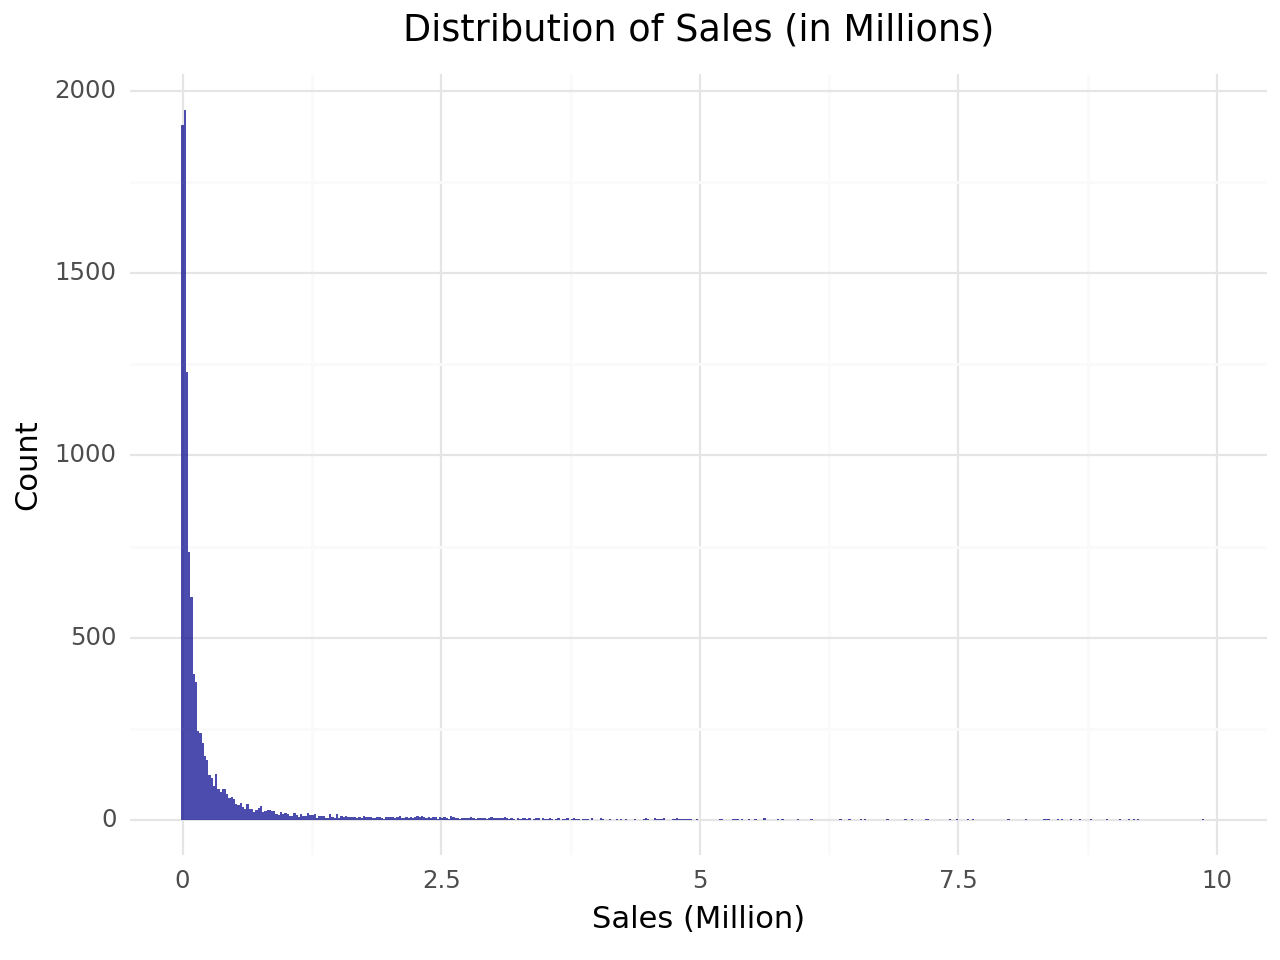

<Figure Size: (640 x 480)>

In [27]:
# Create ggplot of sales
plot_sales = ggplot(data, aes(x='sales_mil')) + \
    geom_histogram(fill='darkblue', alpha=0.7) + \
    labs(x='Sales (Million)', y='Count', title='Distribution of Sales (in Millions)') + \
    theme_minimal() + \
    theme(plot_title=element_text(hjust=0.5))
plot_sales

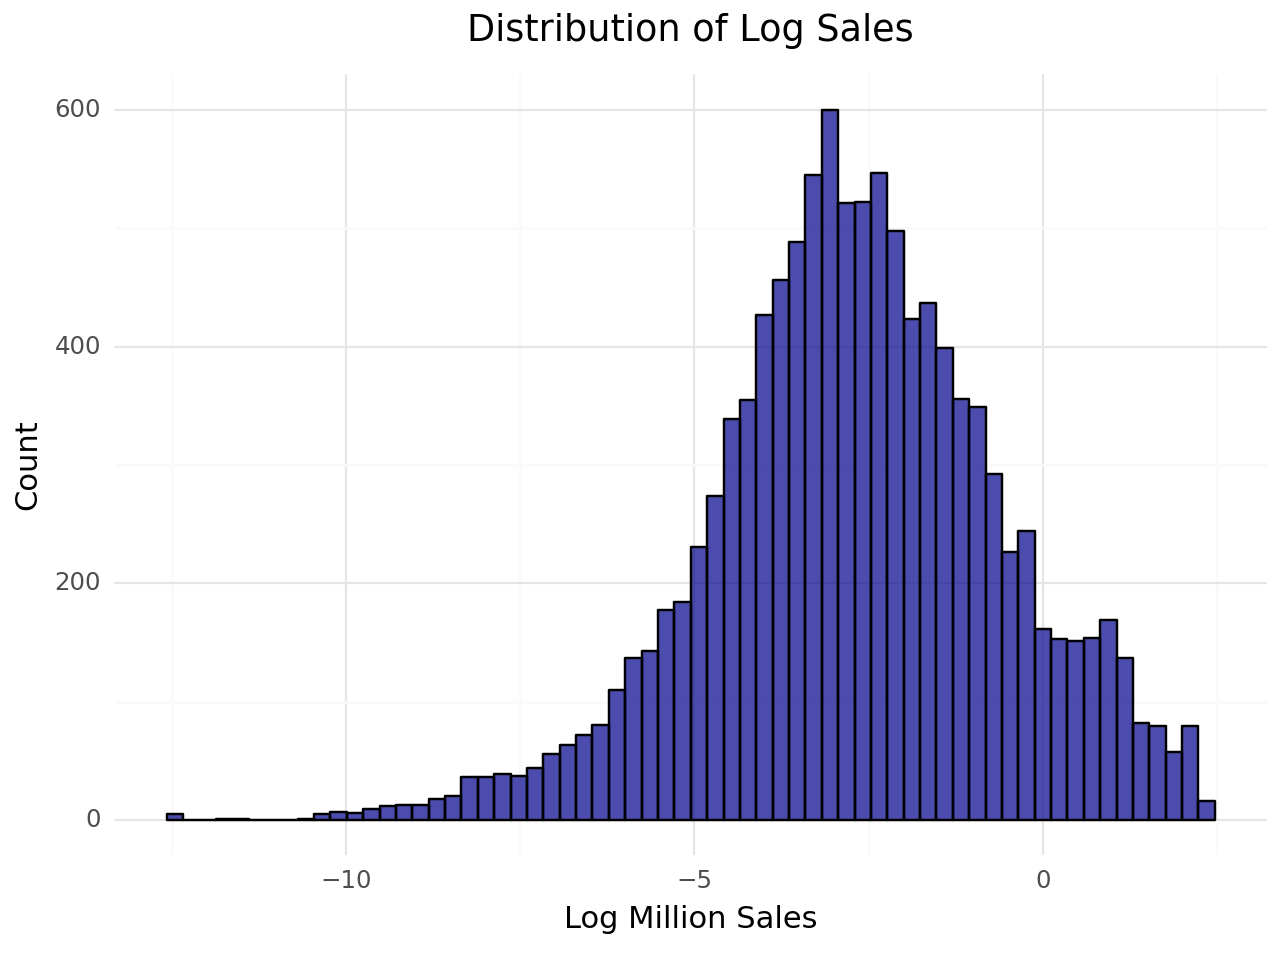

<Figure Size: (640 x 480)>

In [28]:
# Create ggplot of log sales
plot_sales = ggplot(data, aes(x='sales_mil_log')) + \
    geom_histogram(fill='darkblue', color='black', alpha=0.7) + \
    labs(x='Log Million Sales', y='Count', title='Distribution of Log Sales') + \
    theme_minimal() + \
 theme(plot_title=element_text(hjust=0.5))
plot_sales

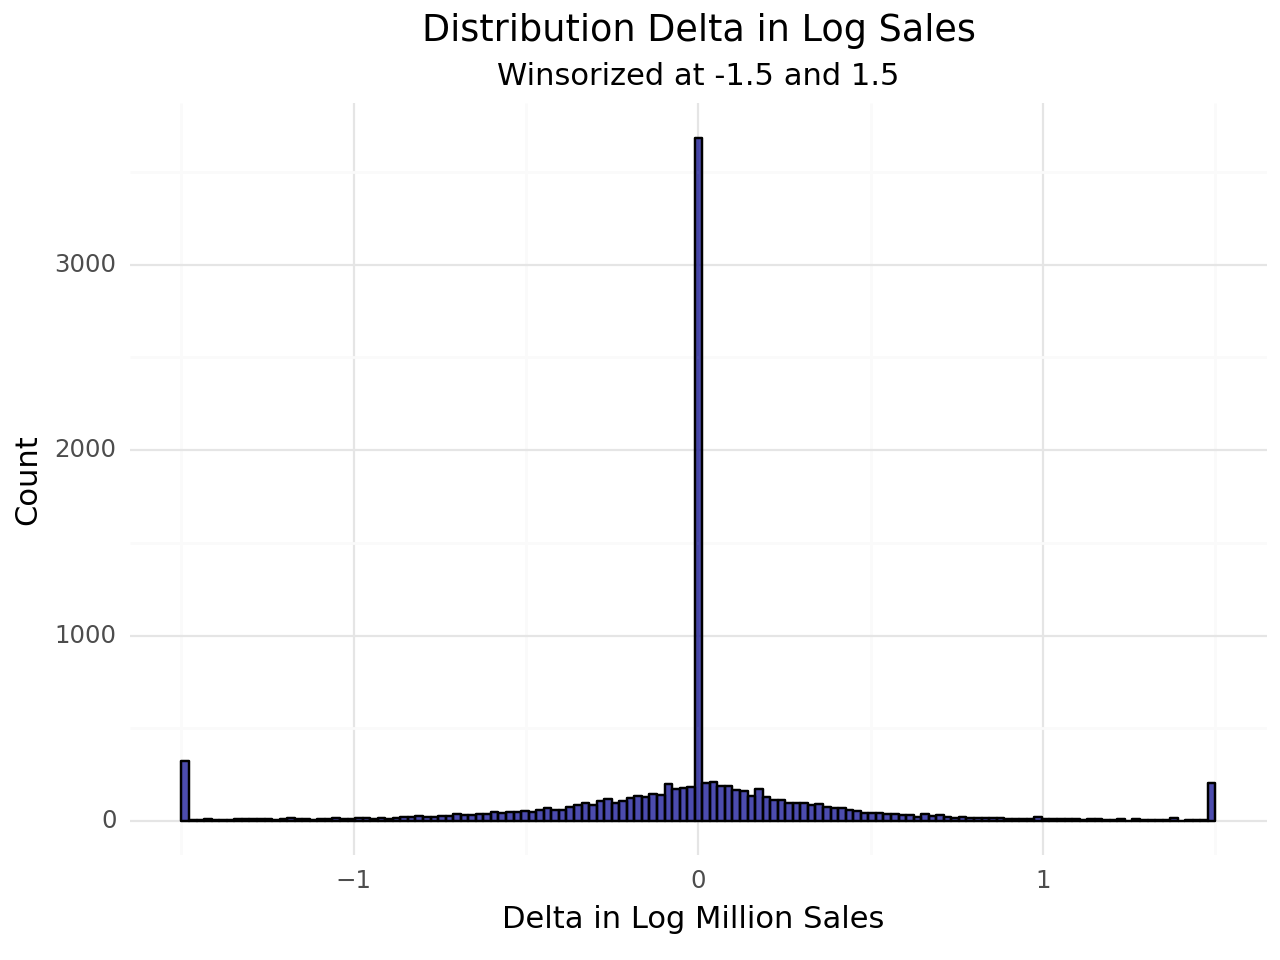

<Figure Size: (640 x 480)>

In [29]:
# create ggplot of growth in log sales 
plot_sales = ggplot(data, aes(x='d1_sales_mil_log_mod')) + \
    geom_histogram(fill='darkblue', color='black', alpha=0.7) + \
    labs(x='Delta in Log Million Sales ', y='Count', title='Distribution Delta in Log Sales') + \
    theme_minimal() + \
    labs(subtitle = 'Winsorized at -1.5 and 1.5') + \
 theme(plot_title=element_text(hjust=0.5),
       plot_subtitle=element_text(hjust=0.5))
plot_sales

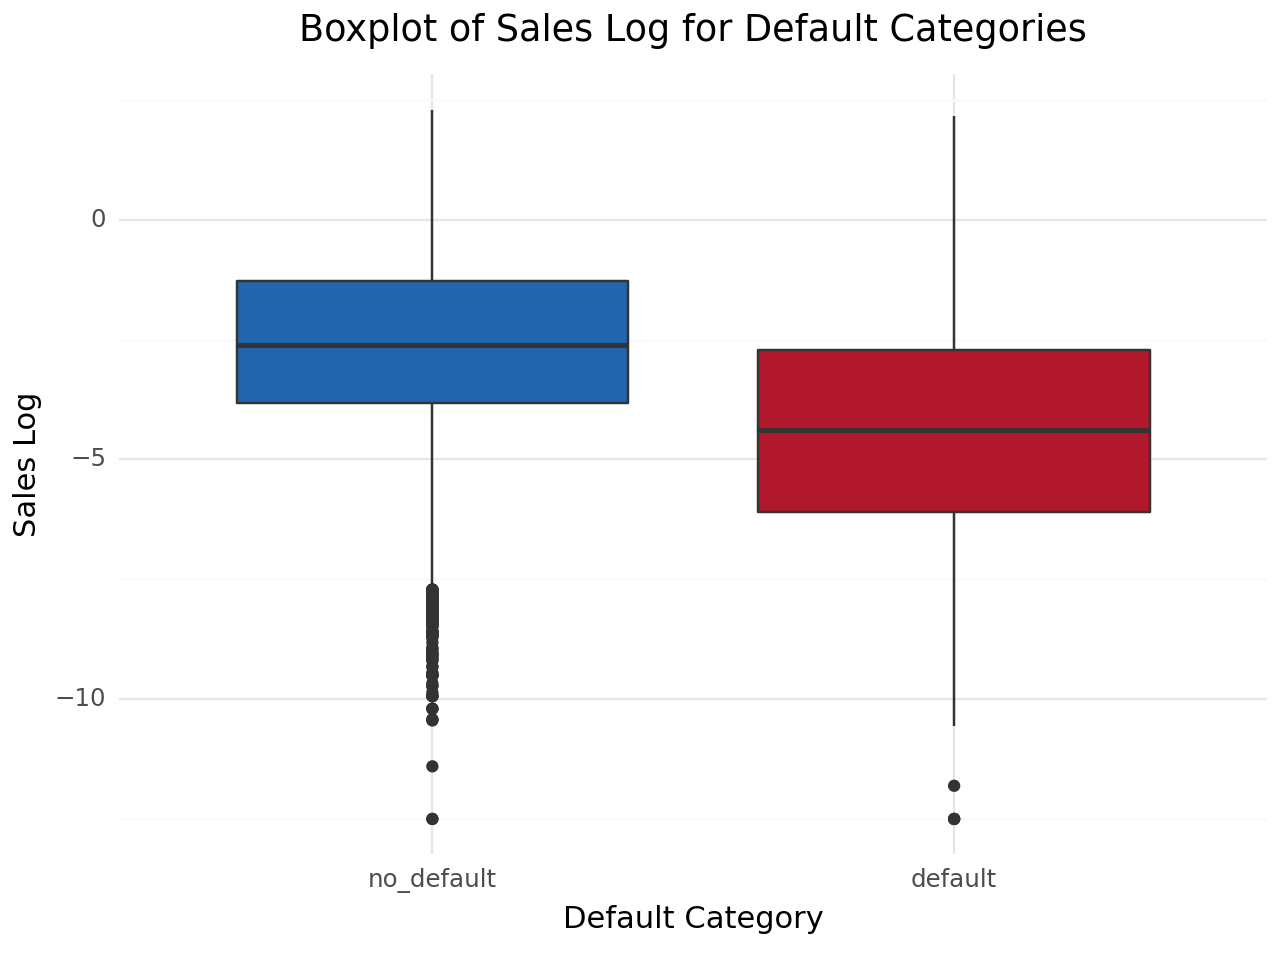

<Figure Size: (640 x 480)>

In [30]:
# create ggplot for sales in default categories
(ggplot(data, aes(x='default_f', y='sales_mil_log', fill='default_f')) + 
 geom_boxplot() +
 labs(
    title="Boxplot of Sales Log for Default Categories",
    x="Default Category",
    y="Sales Log",
    fill="Default Category"
 ) +
 scale_fill_manual(values=["#2166ac", "#b2182b"]) + 
 theme_minimal()+
 theme(plot_title=element_text(hjust=0.5),
       legend_position="none"))

In [31]:

# look at companies by year
def_alive_df = data[['year','default','status_alive']].groupby('year').sum()
# Calculate the ratio of 'default' to 'status_alive' for each year
def_alive_df['ratio'] = round(def_alive_df["default"] / def_alive_df["status_alive"],3)
def_alive_df.T


year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
default,75.000,65.000,77.000,73.000,96.000,96.000,76.000,88.000,73.000,69.000
status_alive,1003.000,1035.000,1089.000,1154.000,1191.000,1161.000,1141.000,1131.000,1102.000,1085.000
ratio,0.075,0.063,0.071,0.063,0.081,0.083,0.067,0.078,0.066,0.064


In [32]:
data.reset_index(drop = True, inplace=True)

In [33]:
holdout_set = data.loc[(data['ind2'] == 26) & (data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0


In [34]:
# Check for potential NAs in the holdout set
empty_columns = holdout_set.columns[holdout_set.isna().any()].tolist()
data[empty_columns].isna().sum()[data[empty_columns].isna().sum() > 0]

Series([], dtype: float64)

In [35]:
# remove the holdout set from the data to get training set
train = data.drop(holdout_set.index)
# get the target variable and the index for the training and holdout set
y_holdout = holdout_set['default']
y_train = train['default']
index_train = y_train.index
index_holdout = y_holdout.index

In [36]:
# Check for potential NAs in the training set
empty_columns = train.columns[train.isna().any()].tolist()
data[empty_columns].isna().sum()[data[empty_columns].isna().sum() > 0]

Series([], dtype: float64)

In [37]:
# print out share of not defaulting and defaulting firms in full, training and holdout set
print('Total')
print(data['default'].value_counts(normalize=True))
print('Train')
print(train['default'].value_counts(normalize=True))
print('Holdout')
print(holdout_set['default'].value_counts(normalize=True))

Total
0    0.928958
1    0.071042
Name: default, dtype: float64
Train
0    0.9272
1    0.0728
Name: default, dtype: float64
Holdout
0    0.945998
1    0.054002
Name: default, dtype: float64


In [38]:
# number of companies in the training set
train.comp_id.nunique()

1604

In [39]:
# number of companies in the holdout set by year
train.year.value_counts().sort_index()

2005    1003
2006    1035
2007    1089
2008    1154
2009    1191
2010    1161
2011    1141
2012    1131
2013    1102
2014      48
Name: year, dtype: int64

In [40]:

print(data.shape, train.shape, holdout_set.shape)
pd.DataFrame({'Table': ['Data', 'Train', 'Holdout'],
               'Rows': [data.shape[0], train.shape[0], holdout_set.shape[0]],
               'Alive': [data.shape[0] - data['default'].sum(), train.shape[0] - train['default'].sum(), holdout_set.shape[0] - holdout_set['default'].sum()],
               'Defaulted': [data['default'].sum(), train['default'].sum(), holdout_set['default'].sum()],
               'Average Sales': [data['sales_mil'].mean(), train['sales_mil'].mean(), holdout_set['sales_mil'].mean()],
               'Minimum Sales': [data['sales_mil'].min(), train['sales_mil'].min(), holdout_set['sales_mil'].min()],
               'Maximum Sales': [data['sales_mil'].max(), train['sales_mil'].max(), holdout_set['sales_mil'].max()]})

(11092, 201) (10055, 201) (1037, 201)


,Table,Rows,Alive,Defaulted,Average Sales,Minimum Sales,Maximum Sales
0,Data,11092,10304,788,0.447736,0.000004,9.974296
1,Train,10055,9323,732,0.443356,0.000004,9.974296
2,Holdout,1037,981,56,0.490202,0.001070,9.576485


## 3. Model Building

***Pre-define Loss Function***

In [41]:
# cross validation method
k = KFold(n_splits = 5, shuffle = True, random_state = 20240301)

# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

FP = 3
FN = 15
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)

### ***Variable Selection***

In [42]:
# "raw" variables from original data
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales_mil",
    "sales_mil_log",
    "share_eq",
    "subscribed_cap"
]
# quality variables
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
# engineered variables
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl"
]
# engineered variables 2
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad"
]
# engineered variables 3
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
        or col.startswith("flag_")
    ):
        engvar3.append(col)
# delta variables        
d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
        "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log",
        "year",'d1_inventories_pl', 'd1_personnel_exp_pl', 'd1_material_exp_pl', 
        'd1_total_assets_bs', 'd1_intang_assets_bs', 'd1_inc_bef_tax_pl', 'd1_extra_inc_pl']
# human resources variables
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [43]:
#Creat dummy columns from category variables and drop first level
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

firm = pd.concat([data[["age", "age2","new"]],m_region_locmat, urban_mmat], axis=1)

## Linear Probability Models: Logit and Lasso models

In [44]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", \
                          "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2","new"]], m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [45]:
# creating interactions for X5
all_interactions = ["sales_mil_log:age",
                "sales_mil_log:female",
                "sales_mil_log:profit_loss_year_pl",
                "sales_mil_log:foreign_management",
                "female:foreign_management",
                "ceo_young:share_eq_bs",
                "ceo_young:extra_profit_loss_pl",
                "origin:foreign_management",
                "female : sales_mil_log_sq",
                "personnel_exp : sales_mil",
                "personnel_exp : extra_profit_loss",
                "urban_m:sales_mil_log",
                "urban_m:sales_mil_log_sq",
                "urban_m:d1_sales_mil_log_mod",
                "urban_m:profit_loss_year_pl",
                "urban_m:fixed_assets_bs",
                "urban_m:share_eq_bs",
                "urban_m:curr_liab_bs",
                "urban_m:age",
                "year:age",
                "year:sales_mil_log",
                "year:sales_mil_log_sq",
                "year:d1_sales_mil_log_mod",
                "year:profit_loss_year_pl",
                "year:fixed_assets_bs",
                ]

In [46]:
intmat = patsy.dmatrix(
    "0 + " + " + ".join(all_interactions), data, return_type="dataframe"
)

# drop first level to get k-1 dummies of k categorical levels
for col in intmat.columns:
    if col.endswith('C(urban_m)[1]') or col.startswith('C(year)[-1]'):
        intmat = intmat.drop([col], axis=1)

X5 = pd.concat([X4, intmat], axis=1)

logitvars = X5

In [47]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [48]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, # simply the number of folds
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240301)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 58 s
Wall time: 17.9 s


In [49]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.266884,0.262850,0.260806,0.258486,0.285965
1,0.246299,0.246150,0.243759,0.238006,0.267671
2,0.242866,0.244143,0.243903,0.239468,0.249172
3,0.255942,0.254357,0.251867,0.249734,0.269082
4,0.241147,0.241735,0.240974,0.238098,0.262278


#### Lasso logit

In [50]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [51]:
# train lasso for accuracy
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy',
    solver = 'liblinear',
    random_state = 20240301)

In [52]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: total: 1min 16s
Wall time: 1min 17s


In [53]:
# best lambda for lasso
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.0004641588833612782

In [54]:
# coefficients of lasso models
create_coef_matrix(normalized_logitvars, logit_models["LASSO"]).sort_values('coefficient', ascending = False)

,variable,coefficient
31,profit_loss_year_pl_quad,0.282999
2,total_assets_bs,0.210276
162,new,0.174630
183,year[T.2006]:sales_mil_log,0.172494
152,flag_miss_ceo_age,0.164305
...,...,...
167,sales_mil_log:age,-0.207445
169,sales_mil_log:profit_loss_year_pl,-0.257065
12,inc_bef_tax_pl,-0.331571
161,age2,-0.345656


Training for ***Brier-score*** (aka RMSE)

In [55]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20240301)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)


In [56]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [57]:
# CV RMSE for models so far
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.266884,0.262850,0.260806,0.258486,0.285965,0.261138
1,0.246299,0.246150,0.243759,0.238006,0.267671,0.238832
2,0.242866,0.244143,0.243903,0.239468,0.249172,0.241626
3,0.255942,0.254357,0.251867,0.249734,0.269082,0.250706
4,0.241147,0.241735,0.240974,0.238098,0.262278,0.238011


AUC using no loss fn

In [58]:
CV_AUC_folds = dict()

In [59]:
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240301)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [60]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', 
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20240301)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: total: 1min 5s
Wall time: 1min 5s


In [61]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [62]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [63]:
# cv summary of models so far
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,4.0,0.250628,0.718428
X2,9.0,0.249847,0.748443
X3,36.0,0.248262,0.760011
X4,167.0,0.244758,0.786489
X5,258.0,0.266834,0.657986
LASSO,188.0,0.246062,0.775393


#### X4 or Lasso seems to be the best model

In [64]:
# rmse on the holdout set with the best model
best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.213

**Discrete ROC (with thresholds in steps) on holdout**

In [65]:
# tresholds in step for ROC curve
thresholds = [i/100 for i in range(5, 80, 5)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
expected_losses = []  # Initialize a list to store expected losses

for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

    # Calculate expected loss
    curr_expected_loss = (fp * FN+ fn *FN) / len(y_holdout)
    expected_losses.append(curr_expected_loss)

# Create DataFrame
tpr_fpr_expected_loss = pd.DataFrame({
    'thresholds': thresholds,
    'true_positive_rates': true_positive_rates,
    'false_positive_rates': false_positive_rates,
    'expected_losses': expected_losses  # Add the new column for expected losses 
})

tpr_fpr_expected_loss

,thresholds,true_positive_rates,false_positive_rates,expected_losses
0,0.05,0.660714,0.204893,3.182257
1,0.10,0.410714,0.068298,1.446480
2,0.15,0.267857,0.029562,1.012536
3,0.20,0.232143,0.017329,0.867888
4,0.25,0.196429,0.009174,0.781099
5,0.30,0.160714,0.008155,0.795564
6,0.35,0.142857,0.006116,0.781099
7,0.40,0.071429,0.003058,0.795564
8,0.45,0.053571,0.003058,0.810029
9,0.50,0.017857,0.002039,0.824494


In [66]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[0],' (default): ',counts[0])

0  (no default):  1034
0  (default):  1034


In [67]:
# confusion matrix
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)

holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2.T

,Actual no default,Actual default
Predicted no default,734,17
Predicted default,247,39


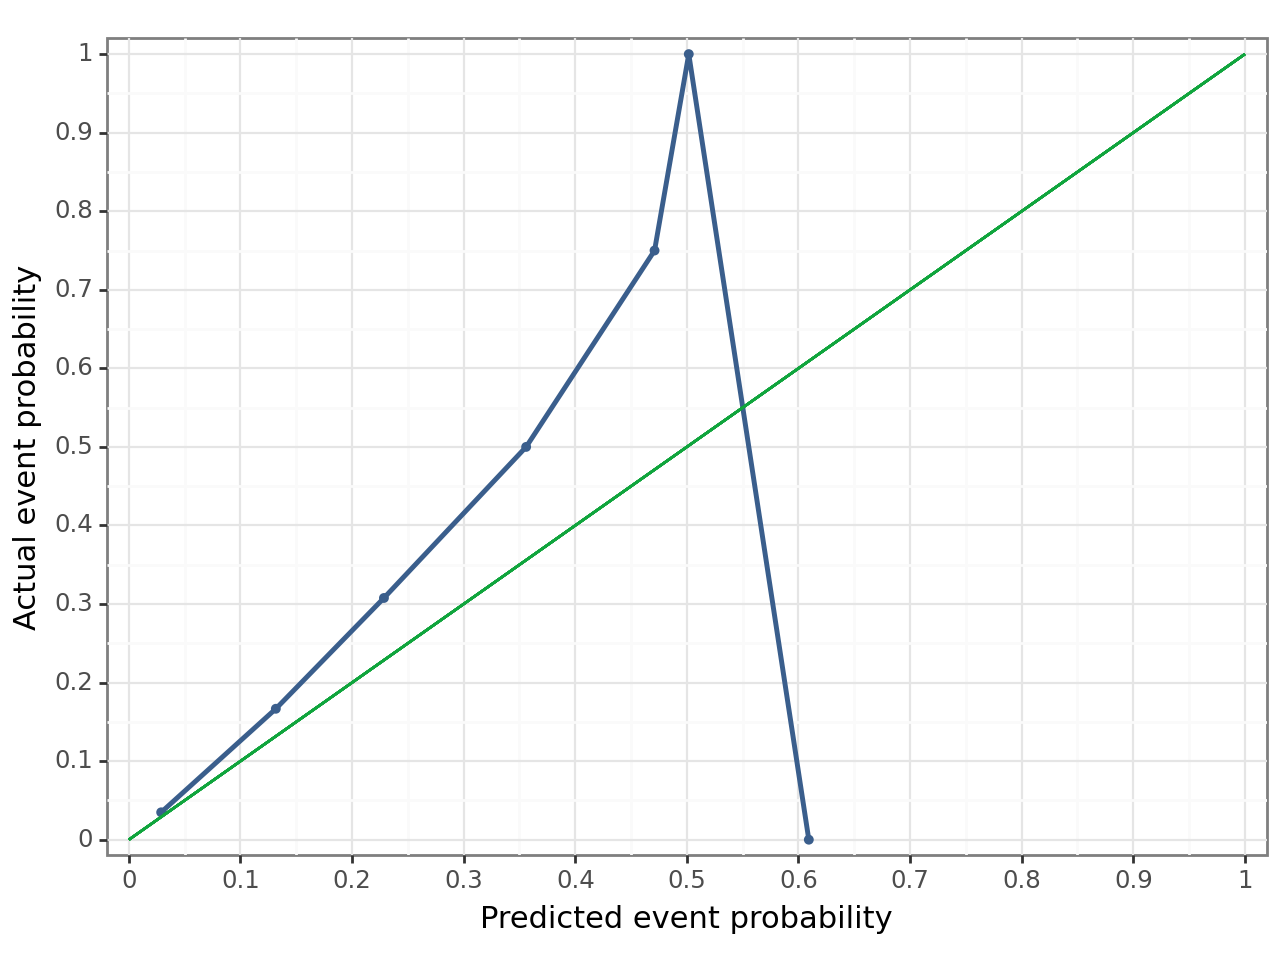

<Figure Size: (640 x 480)>

In [68]:
# predicted vs actual event probability
holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout, 
    file_name = "DA3_A3_calibration_plot.png",
    prob_var='best_logit_no_loss_pred', 
    actual_var='default',
    y_lab="Actual event probability", 
    n_bins=10, 
    breaks=None)

In [69]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

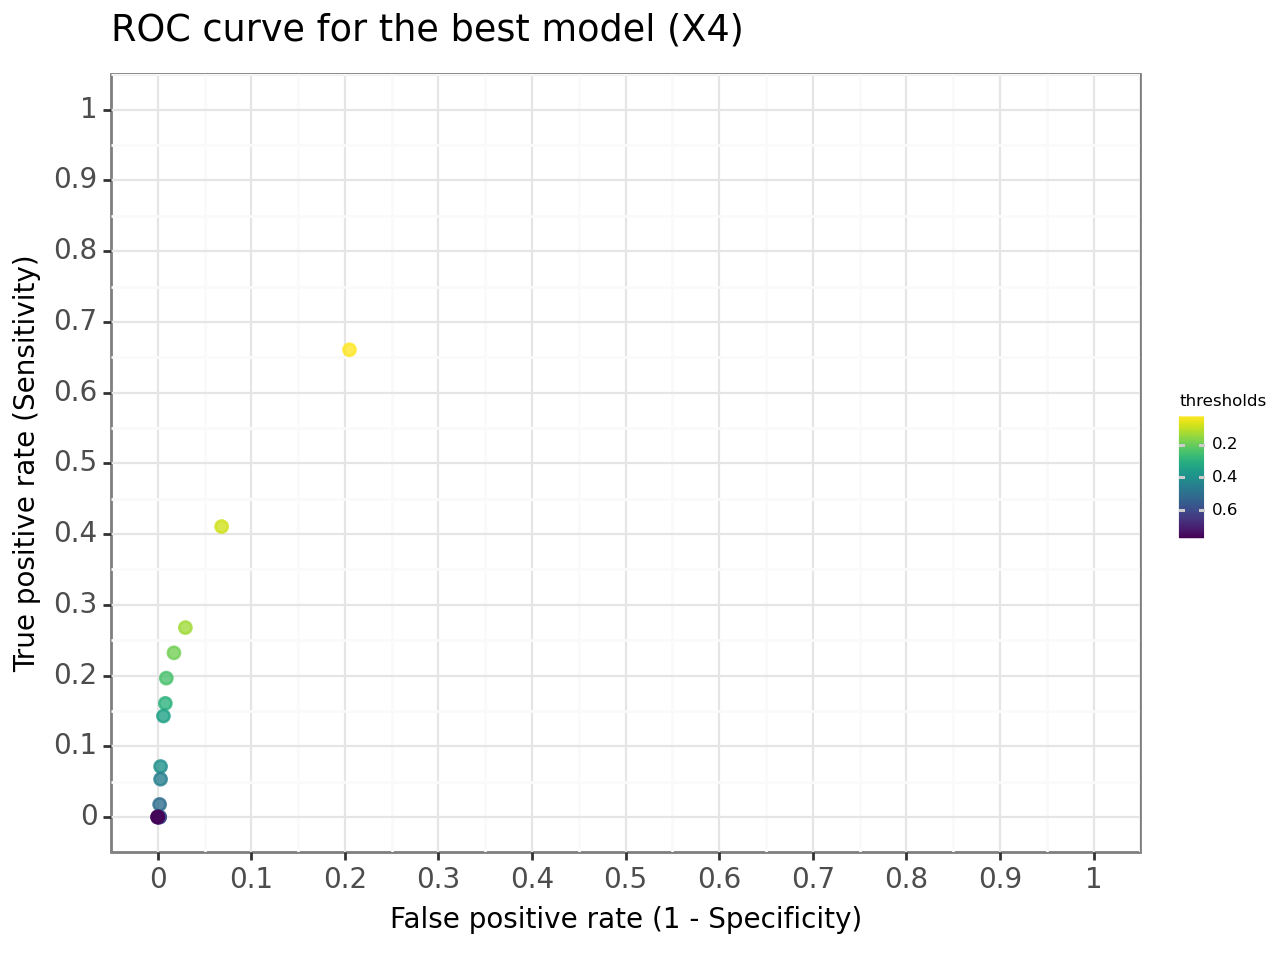

<Figure Size: (640 x 480)>

In [70]:
# ggplot for roc curve
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(
            x = "False positive rate (1 - Specificity)", 
            y = "True positive rate (Sensitivity)",
            title = 'ROC curve for the best model (X4)'
        )\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=10),
            axis_title=element_text(size=10),
            legend_text = element_text(size = 6),
            legend_title = element_text(size = 6),
            legend_key_size=6)

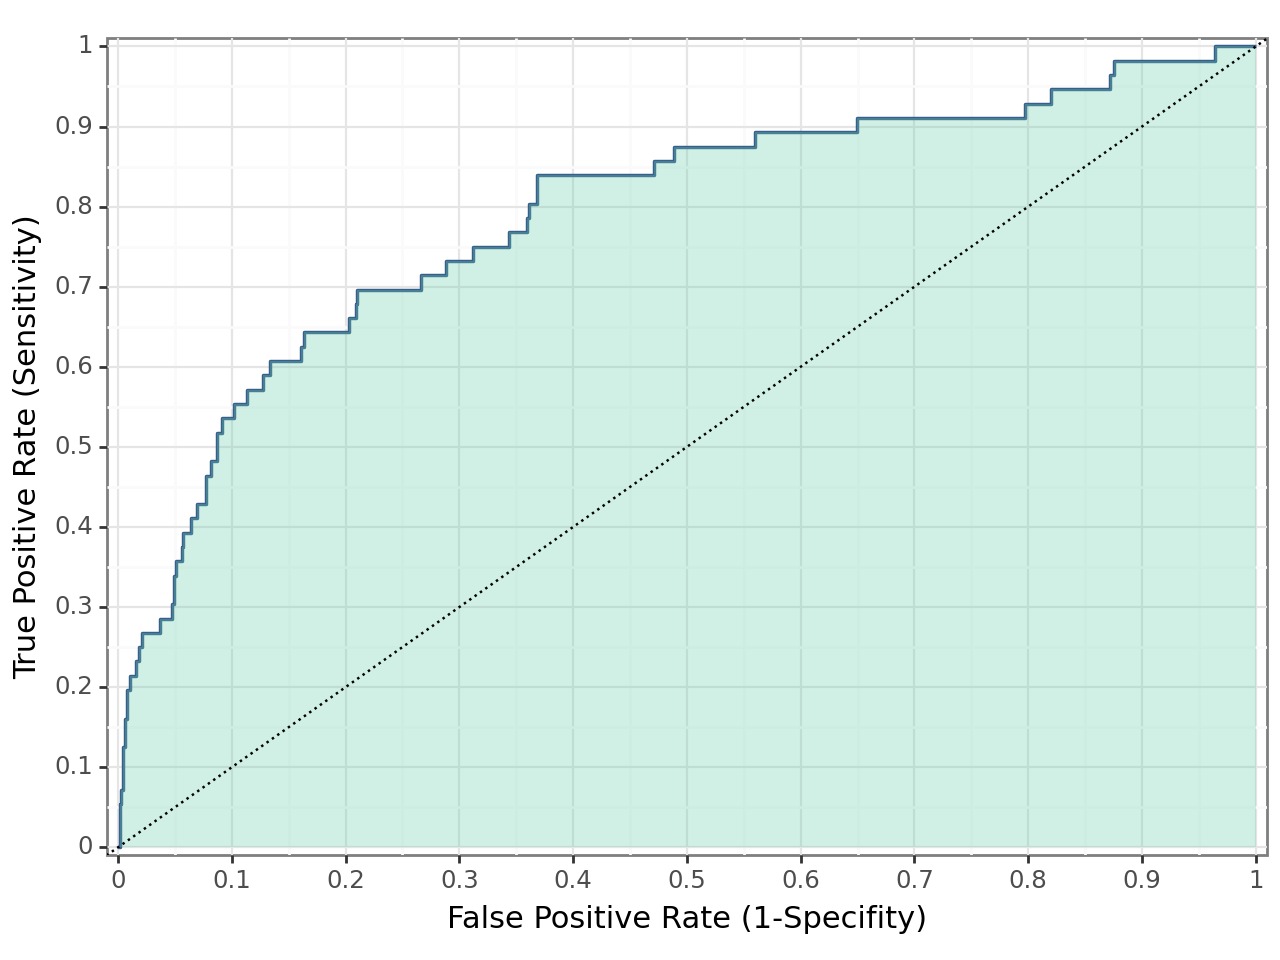

<Figure Size: (640 x 480)>

In [71]:
# ggplot for roc curve with predefined function
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

### Loss Function on Logit and lasso

AUC with LOSS function

In [72]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [73]:
fold5_all_coords['X1']

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,132.0,1879.0,132,1879,2011,inf
1,1.0,0.0,132.0,1878.0,132,1879,2011,0.659624
2,8.0,0.0,132.0,1871.0,132,1879,2011,0.563265
3,8.0,1.0,131.0,1871.0,132,1879,2011,0.554488
4,12.0,1.0,131.0,1867.0,132,1879,2011,0.495192
...,...,...,...,...,...,...,...,...
216,1770.0,130.0,2.0,109.0,132,1879,2011,0.024866
217,1846.0,130.0,2.0,33.0,132,1879,2011,0.022312
218,1846.0,131.0,1.0,33.0,132,1879,2011,0.022279
219,1879.0,131.0,1.0,0.0,132,1879,2011,0.018681


In [74]:
# summary of models so far with loss and threshold
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [75]:
# display summary
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.126053,0.097470,0.912680,0.844356
1,X2,0.142186,0.163054,0.895077,0.848831
2,X3,0.166066,0.143916,0.894182,0.842864
3,X4,0.169076,0.181857,0.841671,0.790651
4,X5,0.180075,0.205742,1.024565,0.939831
5,LASSO,0.164246,0.167868,0.847638,0.796619


### Loss plot based on Fold5 in CV

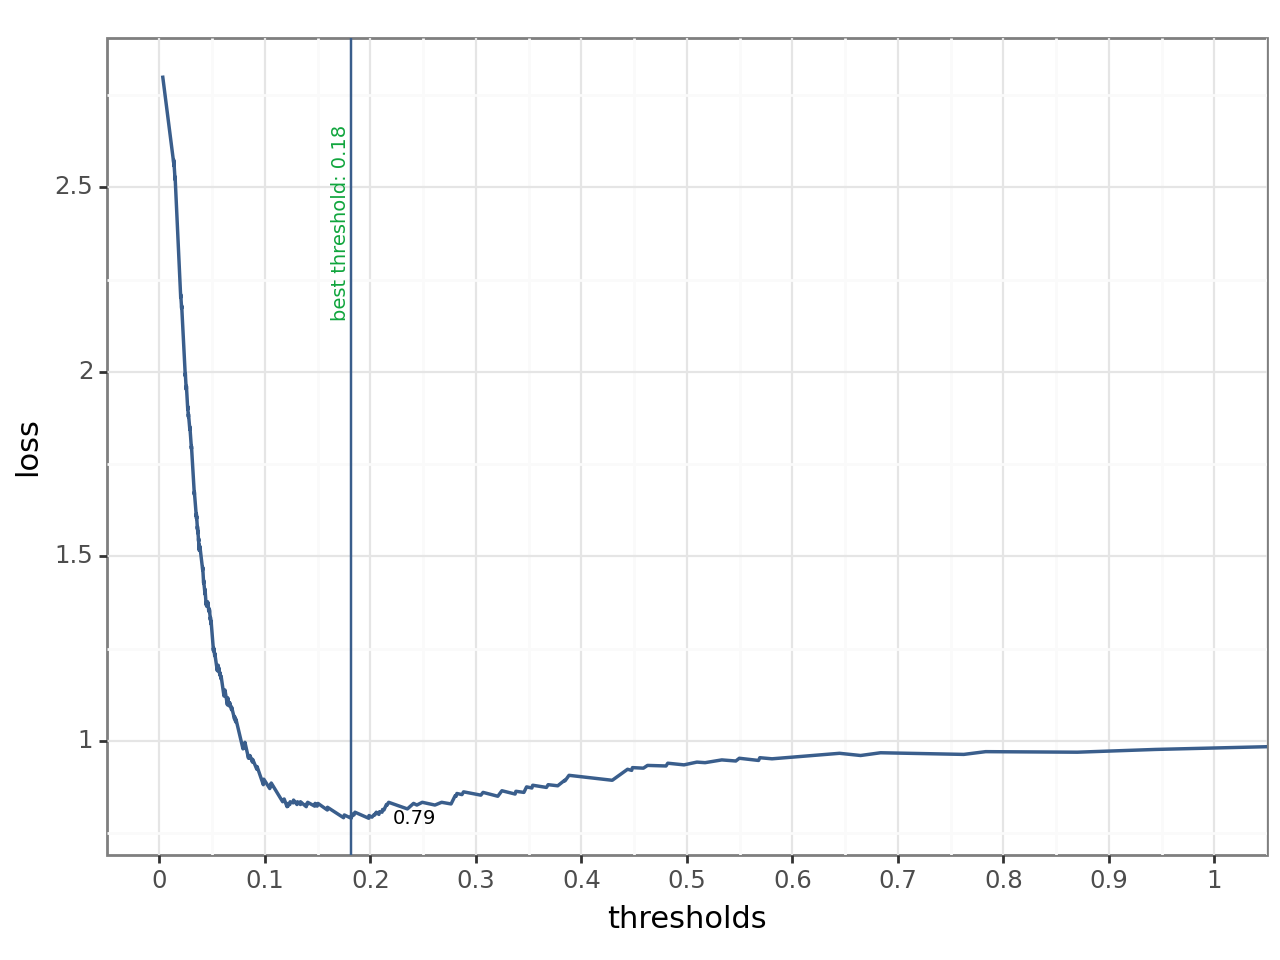

<Figure Size: (640 x 480)>

In [76]:
model_to_plot = 'X4'
create_loss_plot(
    fold5_all_coords[model_to_plot], 
    fold5_threshold[model_to_plot], 
    fold5_expected_loss[model_to_plot])

#### ROC plot plot based on Fold5 in CV

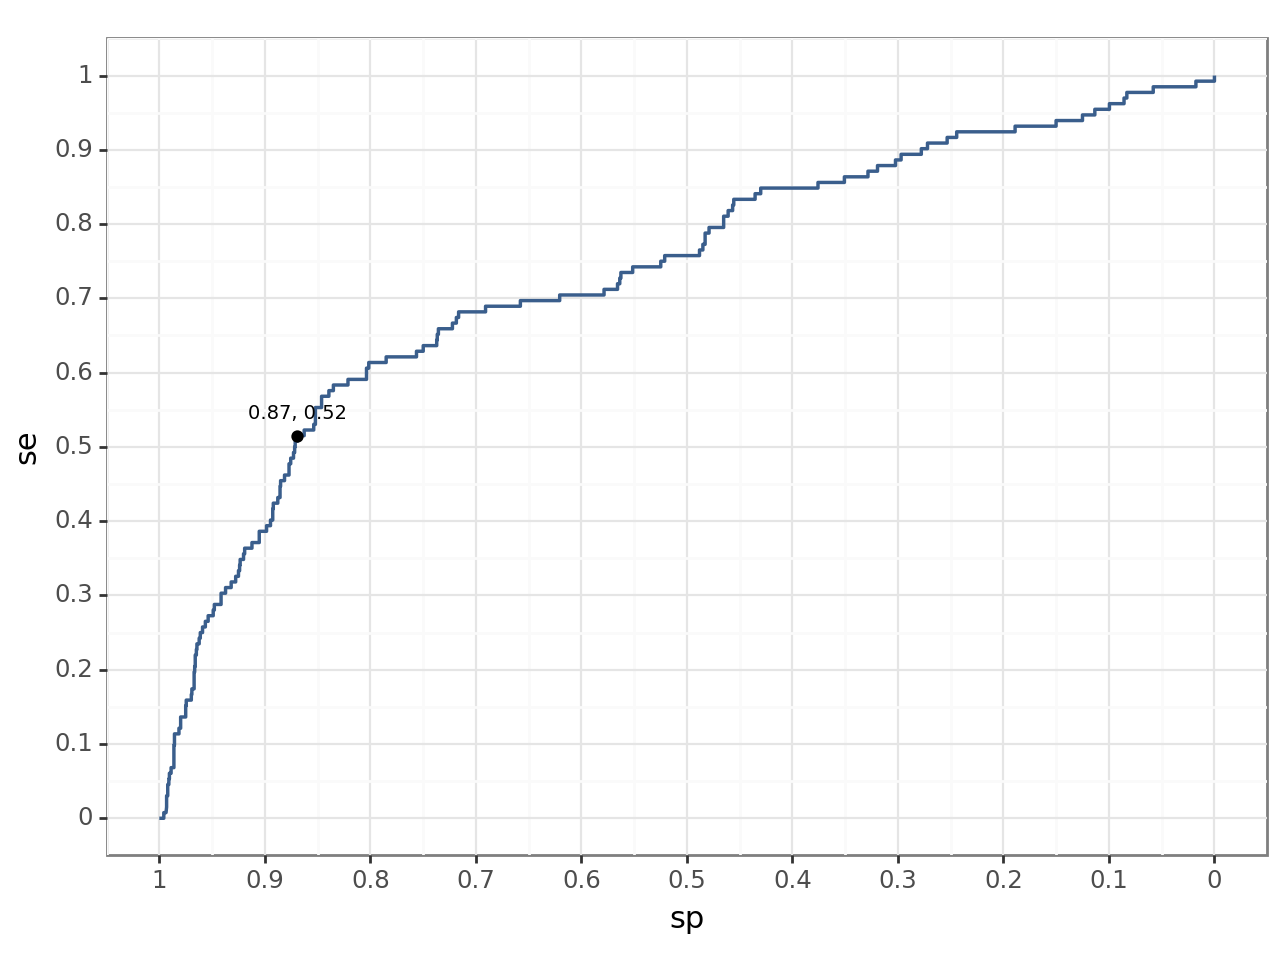

<Figure Size: (640 x 480)>

In [77]:
model_to_plot = 'X1'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot])

#### Pick best model based on average expected loss

### X4

In [78]:
# optimal threshold for the best model
best_logit_optimal_treshold = best_thresholds_cv["X4"]
best_logit_optimal_treshold

0.16907595511033766

In [79]:
# expected loss on the holdout set with the best model so far
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.668

In [80]:
# confusion matrix for the best model so far
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3.T

,Actul no defaul,Actual default
Predicted no default,960,42
Predicted default,21,14


### 2.2 ***Random Forest***

In [81]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales_mil",
    "sales_mil_log",
    "share_eq",
    "subscribed_cap"
]

In [82]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["d1_sales_mil_log",'sales_mil'] + rawvars + hr + d1 + qualityvars + engvar], firm], axis=1)

In [83]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

In [84]:
#define features grid for RF
grid = {'max_features': [6,7,8],
        'criterion':['gini'],
        'min_samples_split': [9,10,11]}

elements = len(grid['max_features'])*len(grid['min_samples_split'])        

In [85]:
prob_forest = RandomForestClassifier(
    random_state=20240205, 
    n_estimators=500, 
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='accuracy',
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [86]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 14.7 s
Wall time: 1min 24s


In [87]:
# cv accuracy for rf
cv_accuracy = np.zeros([elements]) # change 
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.92869219, 0.92799602, 0.92819493, 0.92769766, 0.92829438,
       0.92859274, 0.92759821, 0.92779712, 0.92799602])

In [88]:
# cv auc for rf
cv_auc = np.zeros([elements])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.81325441, 0.81397172, 0.81433743, 0.81056363, 0.81386586,
       0.81297512, 0.81212871, 0.81364534, 0.81276374])

In [89]:
# cv rmse for rf
cv_rmse = np.zeros([elements])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.24182917, 0.24197994, 0.24203933, 0.24239378, 0.242165  ,
       0.2421939 , 0.24234841, 0.24227062, 0.24230243])

In [90]:
# compare measures for grid elements
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,6,9,0.928692,0.813254,0.241829
1,6,10,0.927996,0.813972,0.241980
2,6,11,0.928195,0.814337,0.242039
3,7,9,0.927698,0.810564,0.242394
4,7,10,0.928294,0.813866,0.242165
5,7,11,0.928593,0.812975,0.242194
6,8,9,0.927598,0.812129,0.242348
7,8,10,0.927797,0.813645,0.242271
8,8,11,0.927996,0.812764,0.242302


In [91]:
# get best features for rf
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 9}

In [92]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p']  = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [93]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20240301, 
        n_estimators=500, 
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split)
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [94]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,132.0,1879.0,132,1879,2011,inf
1,1.0,0.0,132.0,1878.0,132,1879,2011,0.688764
2,1.0,2.0,130.0,1878.0,132,1879,2011,0.579039
3,3.0,2.0,130.0,1876.0,132,1879,2011,0.563673
4,3.0,3.0,129.0,1876.0,132,1879,2011,0.543849
...,...,...,...,...,...,...,...,...
232,1826.0,130.0,2.0,53.0,132,1879,2011,0.001167
233,1847.0,130.0,2.0,32.0,132,1879,2011,0.000476
234,1847.0,132.0,0.0,32.0,132,1879,2011,0.000393
235,1853.0,132.0,0.0,26.0,132,1879,2011,0.000154


In [95]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [96]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [97]:
# create summary for rf
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.242,0.813,0.183,0.227,0.822,0.803


### Summary for training

In [98]:
# create summary of model measures on training set
nvars['rf_p'] = len(rfvars.columns)

summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,4,0.250628,0.718428,0.126053,0.912680
1,X2,9,0.249847,0.748443,0.142186,0.895077
2,X3,36,0.248262,0.760011,0.166066,0.894182
3,X4,167,0.244758,0.786489,0.169076,0.841671
4,X5,258,0.266834,0.657986,0.180075,1.024565
5,LASSO,188,0.246062,0.775393,0.164246,0.847638
6,rf_p,65,0.241829,0.813254,0.182552,0.821979


**Take model to holdout and estimate RMSE, AUC and expected loss**

In [99]:
# auc for best model: random forest on holdout
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 4)

0.8353

In [100]:
# rmse for best model: random forest on holdout 
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 4)

0.2093

**ROC AUC  on holdout**

**Expected loss on holdout**

In [101]:
# Checking id the positive class is above the optimal threshold, if its less than the threshold, it assings a 0
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["rf_p"], 0, 1
)

# Creating a confusion matrix for the holdout set
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()

# Calculating the expected loss for the holdout set
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.561

In [102]:
# confusion matrix on holdout set
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3

,Predicted no default,Predicted default
Actul no defaul,927,54
Actual default,28,28


In [103]:
# define function to plot roc curve for holdout
def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

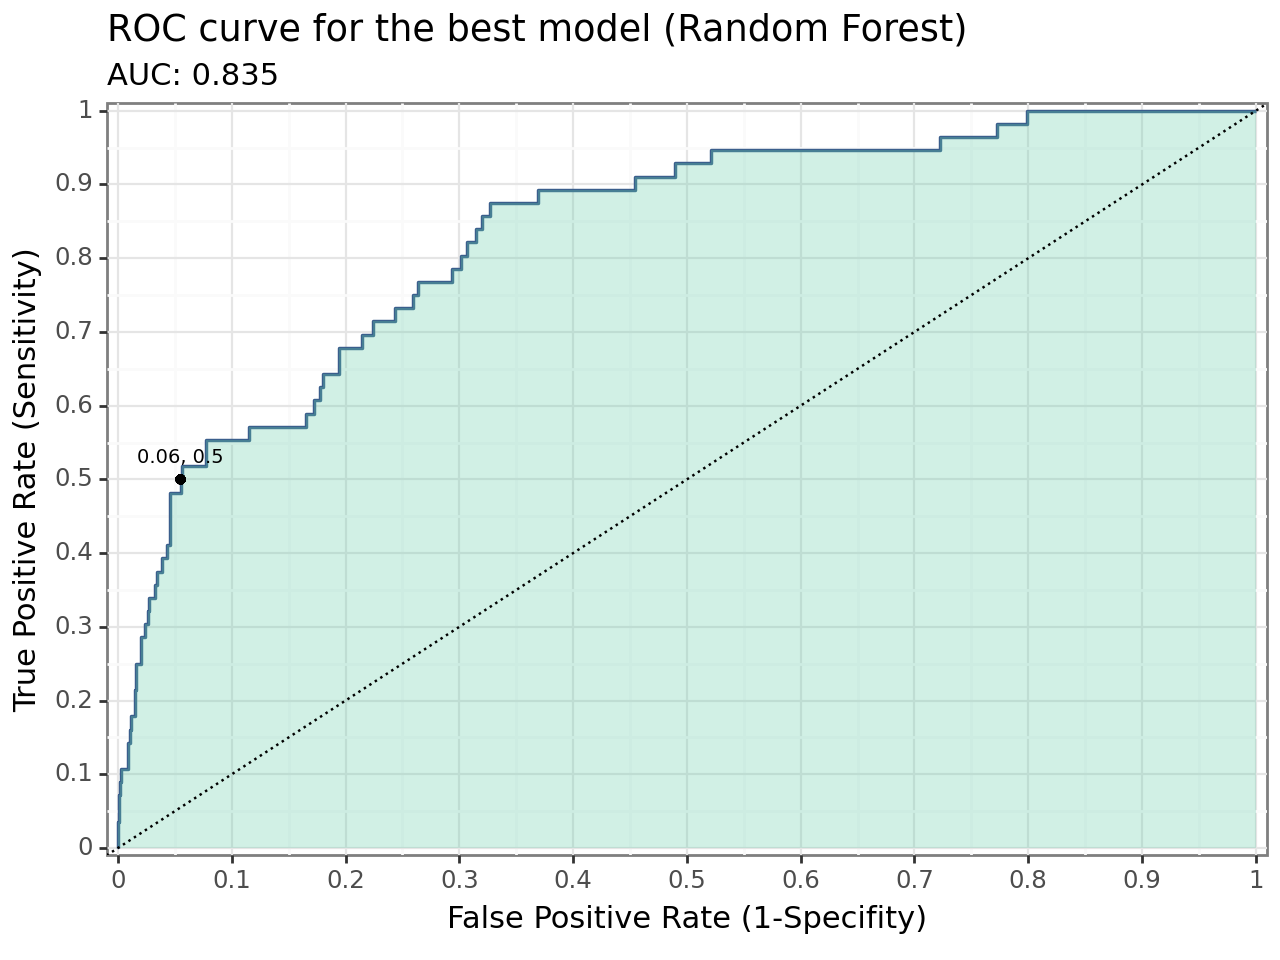

<Figure Size: (640 x 480)>

In [104]:
# graph roc and treshold for best model
create_roc_plot(y_holdout, rf_predicted_probabilities_holdout) + \
    ggtitle("ROC curve for the best model (Random Forest)") + \
    geom_point(aes(x = 1 - (tn/(tn+fp)), y = (tp/(fn+tp))), size = 1) +\
    labs(subtitle="AUC: " + str(round(auc_rf, 3))) + \
    annotate(geom="text", 
         x=(1 - (tn / (tn + fp))), 
         y=((tp / (fn + tp)) + 0.03),
         label=str(round(1 - (tn / (tn + fp)), 2)) + ', ' + str(round((tp / (fn + tp)), 2)), 
         size=7)

In [105]:
all_coords_rf.loc[all_coords_rf['thresholds'] == fold5_threshold_rf]

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
70,118.0,48.0,84.0,1761.0,132,1879,2011,0.227238


In [106]:
# measures for best model on holdout
best_model_df = pd.DataFrame({
    'Brier-Score / RMSE': [rmse_rf],
    'AUC': [auc_rf],
    'Best Threshold': [best_thresholds_cv['rf_p']],
    'Accuracy': (tn+tp)/len(y_holdout),
    'Sensitivity': tp/(fn+tp),
    'Specificity': tn/(tn+fp),
})
best_model_df

,Brier-Score / RMSE,AUC,Best Threshold,Accuracy,Sensitivity,Specificity
0,0.209259,0.835281,0.182552,0.920926,0.5,0.944954


In [107]:
# In addition, report the same descriptive statistics: number of firms, firms defaulted and stayed
# alive. Mean of sales, minimum and maximum values. This helps our work to evaluate and compare
# your results.

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0


### ***GBM***

In [108]:
numerical_columns = [
    'sales_mil', 'd1_sales_mil_log','d1_sales_mil_log_mod','d1_sales_mil_log_mod_sq','curr_assets', 'curr_liab',
    'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
    'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
    'material_exp', 'personnel_exp', 'profit_loss_year',
    'share_eq', 'subscribed_cap', 'ceo_age', 'labor_avg_mod', 'age', 'age2','d1_inventories_pl','d1_personnel_exp_pl',
    'd1_material_exp_pl','d1_total_assets_bs','d1_intang_assets_bs','d1_inc_bef_tax_pl','d1_extra_inc_pl','total_assets_bs','fixed_assets_bs',
    'liq_assets_bs', 'curr_assets_bs', 'share_eq_bs', 'subscribed_cap_bs',
       'intang_assets_bs', 'extra_exp_pl', 'extra_inc_pl',
       'extra_profit_loss_pl', 'inc_bef_tax_pl', 'inventories_pl',
       'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl',
]

categorical_columns = [
    'female', 'flag_high_ceo_age', 'flag_low_ceo_age','flag_miss_ceo_age','ceo_count','flag_low_d1_sales_mil_log','flag_high_d1_sales_mil_log',
    'flag_miss_labor_avg', 'foreign_management', 'balsheet_length',
    'balsheet_notfullyear', 'new',
    'C(m_region_loc)[East]',
    'C(m_region_loc)[West]', 'C(urban_m)[2.0]', 'C(urban_m)[3.0]',"year",'balsheet_flag'
]

# Filter columns based on their type
numerical_data = rfvars[numerical_columns]
categorical_data = rfvars[categorical_columns]

In [109]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Assuming XGBoost is the gradient boosting classifier you want to use

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=20240205)

# Initialize GridSearchCV for XGBoost
xgb_grid = GridSearchCV(
    xgb_model, 
    xgb_param_grid, 
    cv=k, 
    refit='accuracy',
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1
)

In [110]:
# gridsearch for gbm
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=20, max_features = 10
                                ,n_estimators = 50, random_state=20240205)

tune_grid = {"n_estimators": [300,350,400], "max_depth": [12,13,14],'max_features': [6, 7, 8]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'],
    verbose=10,
    refit='accuracy',
    n_jobs=-1
)

elements = len(tune_grid['n_estimators'])*len(tune_grid['max_depth'] * len(tune_grid['max_features']))
elements

27

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [112]:
%%time
gbm_model_fit = gbm_model_cv.fit(rfvars_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


CPU times: total: 12.8 s
Wall time: 6min 14s


In [113]:
# accuracy
cv_accuracy = np.zeros([elements]) # change 
for i in range(5):
    cv_accuracy = cv_accuracy + gbm_model_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

# auc
cv_auc = np.zeros([elements])
for i in range(5):
    cv_auc = cv_auc + gbm_model_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

# rmse
cv_rmse = np.zeros([elements])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(gbm_model_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

In [114]:
# summarize grid search results
gbm_cv_results = pd.DataFrame({
    'max_features': gbm_model_fit.cv_results_['param_max_features'],
    'n_estimators': gbm_model_fit.cv_results_['param_n_estimators'],
    'max_depth': gbm_model_fit.cv_results_['param_max_depth'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [115]:
gbm_cv_results

,max_features,n_estimators,max_depth,cv_accuracy,cv_auc,cv_rmse
0,6,300,12,0.928593,0.789821,0.260494
1,6,350,12,0.928792,0.788936,0.261394
2,6,400,12,0.928294,0.789343,0.262257
3,7,300,12,0.927797,0.796269,0.261869
4,7,350,12,0.927200,0.793141,0.262528
5,7,400,12,0.927996,0.793635,0.262965
6,8,300,12,0.927499,0.789748,0.260710
7,8,350,12,0.927698,0.788831,0.261670
8,8,400,12,0.927698,0.790105,0.262258
9,6,300,13,0.928792,0.792251,0.260534


In [116]:
# optimal features
best_max_features = gbm_model_fit.best_params_['max_features']
best_n_estimators = gbm_model_fit.best_params_['n_estimators']
best_param_max_depth = gbm_model_fit.best_params_['max_depth']
gbm_model_fit.best_params_

{'max_depth': 13, 'max_features': 6, 'n_estimators': 300}

In [117]:
gbm_best_results = gbm_cv_results[
    (gbm_cv_results.max_features == best_max_features) & 
    (gbm_cv_results.n_estimators == best_n_estimators) & 
    (gbm_cv_results.max_depth == best_param_max_depth)]
gbm_best_results_index = gbm_best_results.index.values[0]

CV_RMSE['gbm_p'] = gbm_best_results.cv_rmse.values[0]
CV_AUC['gbm_p'] = gbm_best_results.cv_auc.values[0]

In [118]:
CV_RMSE_folds_gbm_p = list()

for i in range(5):
    rmse = np.sqrt(-1*(gbm_model_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[gbm_best_results_index]
    CV_RMSE_folds_gbm_p.append(rmse)

CV_RMSE_folds['gbm_p'] = CV_RMSE_folds_gbm_p

CV_AUC_folds_gbm_p = list()

for i in range(5):
    rmse = gbm_model_fit.cv_results_['split' + str(i) + '_test_roc_auc'][gbm_best_results_index]
    CV_AUC_folds_gbm_p.append(rmse)

CV_AUC_folds['gbm_p'] = CV_AUC_folds_gbm_p

In [119]:
# add gbm to cv auc summary
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO,gbm_p
0,0.697931,0.743484,0.764881,0.785977,0.654739,0.777133,0.727338
1,0.720809,0.765563,0.773794,0.806753,0.656520,0.816856,0.773356
2,0.708359,0.728168,0.746440,0.776085,0.698168,0.756226,0.811234
3,0.730333,0.763751,0.765413,0.794371,0.640856,0.769007,0.829746
4,0.734709,0.741251,0.749524,0.769260,0.639650,0.757745,0.819578


In [120]:
#gbm with loss
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    


    prob_forest_best = GradientBoostingClassifier(learning_rate=0.1,
        min_samples_split=20,
        max_features = best_max_features,
        n_estimators = best_n_estimators,
        max_depth = best_param_max_depth,
        criterion = 'friedman_mse',
        random_state=20240205)

    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [121]:
expected_loss_cv['gbm_p'] = np.mean(expected_loss)
best_thresholds_cv['gbm_p'] = np.mean(best_thresholds)

In [122]:
# gbm rmse on holdout
prob_gbm_fit_best = gbm_model_fit.best_estimator_
gbm_predicted_probabilities_holdout = gbm_model_fit.predict_proba(rfvars_holdout)[:,1]
rmse_gbm = np.sqrt(mean_squared_error(y_holdout, gbm_predicted_probabilities_holdout))
round(rmse_gbm, 3)

0.221

In [123]:
#gbm auc on holdout
auc_gbm = roc_auc_score(y_holdout, gbm_predicted_probabilities_holdout)
round(auc_rf, 3)

0.835

In [124]:
# gbm expected loss on holdout
holdout_treshold = np.where(gbm_predicted_probabilities_holdout < best_thresholds_cv['gbm_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.645

In [125]:
# confusion matrix for gbm on holdout
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3.T

,Actul no defaul,Actual default
Predicted no default,928,34
Predicted default,53,22


In [126]:
nvars['gbm_p'] = len(rfvars.columns)

In [127]:
# create summary table for all models
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [128]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,4,0.250628,0.718428,0.126053,0.912680
1,X2,9,0.249847,0.748443,0.142186,0.895077
2,X3,36,0.248262,0.760011,0.166066,0.894182
3,X4,167,0.244758,0.786489,0.169076,0.841671
4,X5,258,0.266834,0.657986,0.180075,1.024565
5,LASSO,188,0.246062,0.775393,0.164246,0.847638
6,rf_p,65,0.241829,0.813254,0.182552,0.821979
7,gbm_p,65,0.260534,0.792251,0.000690,0.817205
